# 0.0. Imports

In [1]:
#Requirements
from matplotlib import pyplot         as plt

#Machine Learning
from sklearn import preprocessing     as pp
from sklearn import model_selection   as ms
from sklearn import neighbors         as nh
from sklearn import linear_model      as lm
from sklearn import ensemble          as en
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from xgboost          import XGBClassifier 
 
#Data Extraction & Proccessing
import pandas     as pd
import numpy      as np
from sqlalchemy import create_engine
import psycopg2 as pg
import pandas.io.sql as psql

#Data analisys
import seaborn    as sns
import scikitplot as skplt
import sklearn.metrics  as metrics

#Others
import warnings
import inflection
import pickle
import os
from dotenv import load_dotenv, find_dotenv



/home/heitor/repos/health_insurance_cross_sale/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1. Helper Functions

In [3]:
# def jupyter_settings():
#     %matplotlib inline
#     %pylab inline
#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [25, 12]
#     plt.rcParams['font.size'] = 24
#     display( HTML( '<style>.container { width:100% !important; }</style>') )
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.set_option( 'display.expand_frame_repr', False )
#     sns.set()
    
# jupyter_settings()

warnings.simplefilter("ignore")

def num_attributes(df1):
    num_attributes = df1.select_dtypes(['int64','float64'])
    #Central Tendency - Median, Mean
    mean = pd.DataFrame(num_attributes.apply(np.mean)).T
    median = pd.DataFrame(num_attributes.apply(np.median)).T

    #Dispersion - std, min, max, range, skew, kurtosis
    std = pd.DataFrame(num_attributes.apply(np.std)).T
    min_ = pd.DataFrame(num_attributes.apply(min)).T
    max_ = pd.DataFrame(num_attributes.apply(max)).T
    range_ = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    kurtosis =  pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    m = pd.concat([min_, max_, range_, mean, median, std, skew, kurtosis]).T.reset_index()
    m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m

# prepare dataset for function precision and recall at k
def concat_order_data( x_val, y_val, yhat ):
    
    # copy data
    data = x_val.copy()
    data['response'] = y_val.copy()

    # propensity score
    data['score'] = yhat[:, 1].tolist()

    # sorted clients by propensity score
    data = data.sort_values( 'score', ascending=False )
    
    return data

def precision_at_k( data, k=20000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k( data, k=20000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

# all at k metrics as dataframe
def at_k_metrics( model_name, x_val, y_val, yhat, k=20000 ):
    data = concat_order_data( x_val, y_val, yhat )
    
    pr = precision_at_k( data, k )
    re = recall_at_k( data, k )
    
    return pd.DataFrame({"Precision_at_k": "{}".format(np.round(pr,3)),
                         "Recall_at_k": "{}".format(np.round(re,3))}, index=[model_name])

# stratified cross validation
def cross_validation(model_name, model, x_train, y_train, k=20000 ):
    
    precision_at_k_list = []
    recall_at_k_list = []

    skf = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
    
    for train_index, test_index in skf.split(x_train, y_train):
        
        x_train_cv = x_train.iloc[train_index]
        y_train_cv = y_train.iloc[train_index]
        
        x_test_cv = x_train.iloc[test_index]
        y_test_cv = y_train.iloc[test_index]
        
        # model training
        model.fit(x_train_cv, y_train_cv)
        
        # prediction
        pred = model.predict_proba(x_test_cv)
        
        # concat
        data = x_test_cv.copy()
        data['response'] = y_test_cv.copy()
        
        data['score'] = pred[:, 1].tolist()
        
        data = data.sort_values( 'score', ascending=False )
        
        # measuring at k metrics
        precision_at_k_list.append( precision_at_k( data, k ) )
        recall_at_k_list.append(recall_at_k( data, k ) )
        
    
    precision_at_k_mean, precision_at_k_std = np.round( np.mean( precision_at_k_list ), 2 ), np.round( np.std( precision_at_k_list ), 2 )
    recall_at_k_mean, recall_at_k_std = np.round( np.mean( recall_at_k_list ), 2 ), np.round( np.std( recall_at_k_list ), 2 )
   
    
    return pd.DataFrame({"Precision_at_k": "{} +/- {}".format(precision_at_k_mean, precision_at_k_std),
                         "Recall_at_k": "{} +/- {}".format(recall_at_k_mean, recall_at_k_std)}, index=[model_name])


def conn():
    connection = pg.connect(                                                  
        user = os.getenv("DATABASE_USERNAME"),                                      
        password = os.getenv("DATABASE_PASSWORD"),                                  
        host = os.getenv("DATABASE_IP"),                                            
        port = os.getenv("DATABASE_PORT"),                                          
        database = os.getenv("DATABASE_NAME")                                       
    )           
    return connection

## 0.2. Collect Data

### 0.2.1. CSV

In [10]:
df_raw = pd.read_csv('../datasets/train.csv')

### 0.2.2. Psycopg2

In [11]:
#load credentials from dot-env
load_dotenv()




#connect
connection = conn()
cursor = connection.cursor()

#get table names
query = """
SELECT tablename
FROM pg_tables
WHERE schemaname = 'pa004'
"""

#execute query
cursor.execute(query)
records = cursor.fetchall()
print(records)

#close
cursor.close()
connection.close()

[('users',), ('vehicle',), ('insurance',)]


In [12]:
def df_get_table(query):
    #connect
    connection = conn()
    cursor = connection.cursor()
    
    cursor.execute(query)
    df = psql.read_sql(query, connection)
    return df


In [13]:
#connect
connection = conn()
cursor = connection.cursor()

#queries
query_users = """
SELECT *
FROM pa004.users
"""

query_vehicle = """
SELECT *
FROM pa004.vehicle
"""

query_insurance = """
SELECT *
FROM pa004.insurance
"""

df_users = df_get_table(query_users)



df_vehicle = df_get_table(query_vehicle)



df_insurance = df_get_table(query_insurance)

connection.close()
cursor.close()

df_raw = pd.merge(df_users, df_vehicle, on='id', how='left')
df_raw = pd.merge(df_raw, df_insurance, on='id', how='left')


df_raw.head()

#### 0.2.3.  SQL Alchemy

In [45]:
#queries
query_users = """
SELECT *
FROM pa004.users
"""

query_vehicle = """
SELECT *
FROM pa004.vehicle
"""

query_insurance = """
SELECT *
FROM pa004.insurance
"""

#load credentials from dot-env
load_dotenv()


user = os.getenv("DATABASE_USERNAME"),                                      
password = os.getenv("DATABASE_PASSWORD"),                                  
host = os.getenv("DATABASE_IP"),                                            
port = os.getenv("DATABASE_PORT"),                                          
database = os.getenv("DATABASE_NAME") 

url = f'postgresql://{user[0]}:{password[0]}@{host[0]}:{port[0]}/{database}'

engine = create_engine(url=url)

#connect to db

with engine.connect() as connection:
    records = connection.execute(query_users)
    records = records.fetchall()

    df_users = psql.read_sql(query_users, connection)
    df_vehicle = psql.read_sql(query_vehicle, connection)
    df_insurance = psql.read_sql(query_insurance, connection)

# 1.0. Data Description

In [21]:
df1 = df_raw.copy()

## 1.1. Data Dimension

In [22]:
print(f'Number of cols: {df1.shape[1]}')
print(f'Number of rows: {df1.shape[0]}')

Number of cols: 12
Number of rows: 381109


## 1.2. Data Types

In [23]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

In [24]:
#Rename columns
old_cols = ['id', 'Gender', 'Age', 'DrivingLicense', 'RegionCode',
       'PreviouslyInsured', 'Vehicle_Age', 'VehicleDamage', 'AnnualPremium',
       'PolicySalesChannel', 'Vintage', 'Response']
snakecase = lambda x: inflection.underscore(x)

new_cols = list(map(snakecase, old_cols))
df1.columns = new_cols

In [25]:
#changing types

df1['vehicle_damage'] = df1['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)
df1['annual_premium'] = df1['annual_premium'].astype(int)
df1['region_code'] = df1['region_code'].astype(int)
df1['vehicle_damage'] = df1['vehicle_damage'].astype(int)

df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license         float64
region_code               int64
previously_insured        int64
vehicle_age              object
vehicle_damage            int64
annual_premium            int64
policy_sales_channel      int64
vintage                   int64
response                  int64
dtype: object

## 1.3. Checking NAs


In [26]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4. Data Descriptive 

In [27]:
num_attributes = df1.select_dtypes(['int64','float64'])
cat_attributes = df1.select_dtypes(['int64','float64','datetime64[ns]'])

In [28]:
# #Central Tendency - Median, Mean
# mean = pd.DataFrame(num_attributes.apply(np.mean)).T
# median = pd.DataFrame(num_attributes.apply(np.median)).T

# #Dispersion - std, min, max, range, skew, kurtosis
# std = pd.DataFrame(num_attributes.apply(np.std)).T
# min_ = pd.DataFrame(num_attributes.apply(min)).T
# max_ = pd.DataFrame(num_attributes.apply(max)).T
# range_ = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
# skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
# kurtosis =  pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                      
# m = pd.concat([min_, max_, range_, mean, median, std, skew, kurtosis]).T.reset_index()
# m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
# m

# 2.0. Feature Engineering 

In [29]:
df2 = df1.copy()

In [30]:
df2.columns


Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [31]:
df2['vehicle_age'].unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [32]:
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'less_than_1_year' if x =='< 1 Year' else
                                              'more_than_2_years' if x== '> 2 Years' else
                                             'between_1_and_2_years' )
df2['vehicle_age'].unique()

array(['more_than_2_years', 'between_1_and_2_years', 'less_than_1_year'],
      dtype=object)

# 3.0. EDA

## 3.1. Univariate Analysis


<AxesSubplot:xlabel='response', ylabel='age'>

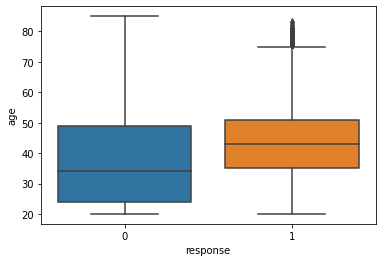

In [33]:
#age
sns.boxplot(x='response',y='age', data=df2)

...

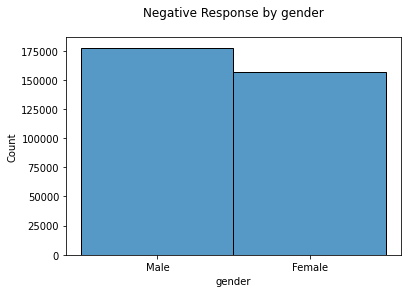

In [34]:
#gender 
aux00 = df2.loc[df2['response']==0, 'gender']
sns.histplot(aux00)
plt.title('Negative Response by gender\n');


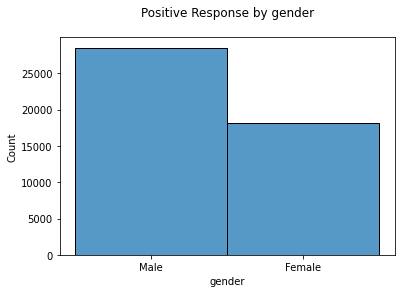

In [35]:
aux00 = df2.loc[df2['response']==1, 'gender']
sns.histplot(aux00)
plt.title('Positive Response by gender\n');

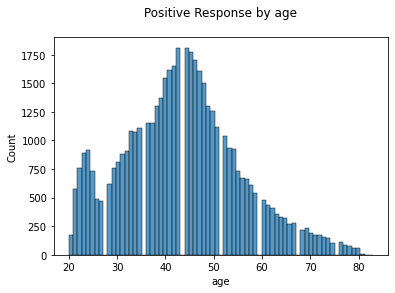

In [36]:
#histogram with distribution of positive response by age
aux00 = df2.loc[df2['response']==1, 'age']
sns.histplot(aux00);
plt.title('Positive Response by age\n');

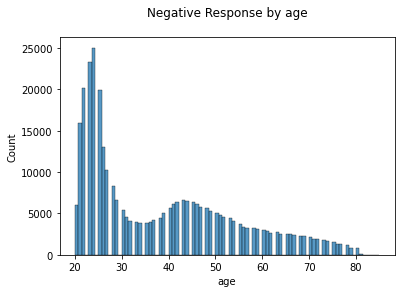

In [37]:
#histogram with distribution of negative response by age
aux00 = df2.loc[df2['response']==0, 'age']
sns.histplot(aux00);
plt.title('Negative Response by age\n');

Young people seems to be less interested in the product.

Its interesting to analyse deeply the age about 40-50


The distribution is concentrated in the ages about 40-50, the volume of the data is reduced rather than negative response

In [38]:
df2['annual_premium'].unique()

array([0, 1])

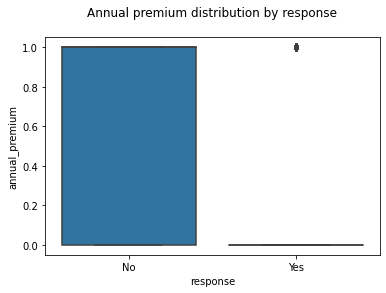

In [39]:
#annual_premium
aux = df2[df2['annual_premium']<100000]
ax = sns.boxplot(y='annual_premium', x='response',data=aux);
ax.set_title('Annual premium distribution by response\n');
ax.set_xticklabels(['No','Yes']);


The distribution seems to be concentrated about 40.000 in both positive and negative responses. This variable alone is not helpful to the model.

There are a lot of outliers

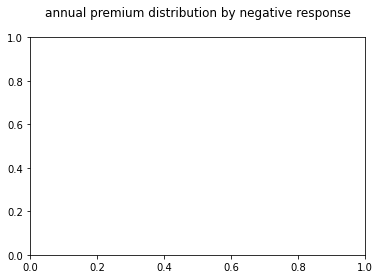

In [40]:
#histogram with distribution of negative response by annual premium
aux = df2[(df2['annual_premium']<100000) & (df2['annual_premium']>10000)]
aux00 = aux.loc[df2['response']==0, 'annual_premium']
sns.histplot(aux00);
plt.title('annual premium distribution by negative response\n');

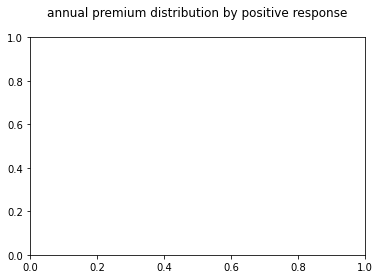

In [41]:
#histogram with distribution of positive response by annual premium
aux00 = aux.loc[df2['response']==1, 'annual_premium']
sns.histplot(aux00);
plt.title('annual premium distribution by positive response\n');

The distribution is almost the same, the only difference is the volume of the data. 
Conclusion: This variable is not helpful alone.

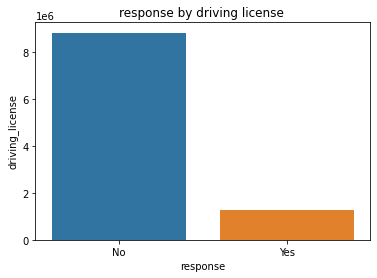

In [42]:
#drive license
aux = df2[['driving_license','response']].groupby('response').sum().reset_index()

ax = sns.barplot(x='response', y='driving_license', data=aux);
ax.set_title('response by driving license ');
ax.set_xticklabels(['No','Yes']);

In [43]:
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux

,response,driving_license,driving_license_perc
0,0,8806914.0,0.875699
1,1,1250098.0,0.124301


This analysis is not helpful alone. It would work with other variables.

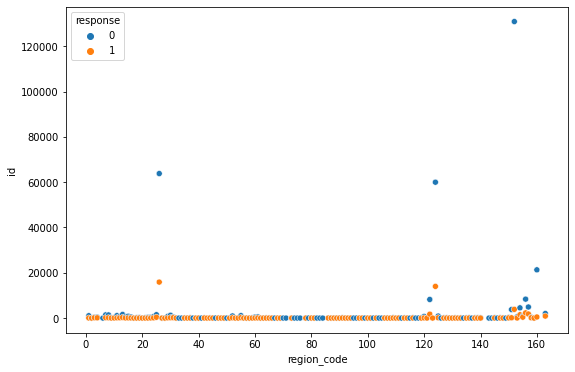

In [44]:
#region code

#region_code ; response; count
aux = df2[['region_code', 'id', 'response']].groupby(['region_code','response']).count().reset_index()
plt.figure(figsize=(9,6))
sns.scatterplot(x='region_code', y='id', hue='response', data=aux);



The most part of the distribution is similar, but it would be interested to check regions with much more one than other response

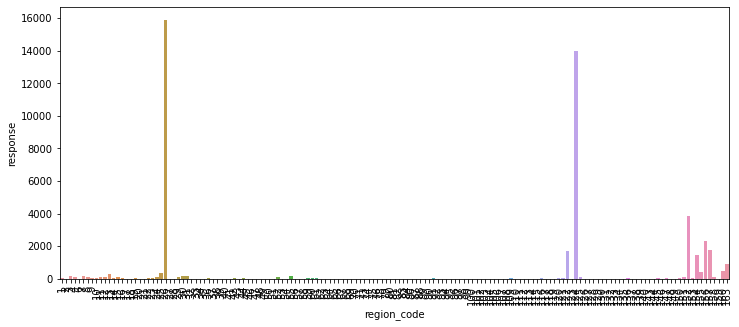

In [45]:
aux = df2[['region_code', 'response']].groupby('region_code').sum().reset_index()
plt.figure(figsize=(12,5))
sns.barplot(x='region_code',y='response',data=aux)
plt.xticks(rotation=90);

Investigate region code with high number of positive response

In [46]:
aux1 = df2.loc[df2['region_code'].isin([3,8,28,29,30,41,46])][['response','region_code']]
#sum of positive response
aux2 = aux1[['response','region_code']].groupby('region_code').sum().reset_index()

#count all responses
aux3 = aux1[['response','region_code']].groupby('region_code').count().reset_index()

#percentage of positive responses
aux4 = aux2
aux4['total_responses'] = aux3['response']
aux4['perc'] = aux2['response']/aux3['response']
aux4.sort_values('perc', ascending=False)


,region_code,response,total_responses,perc
2,28,1,3,0.333333
0,3,159,523,0.304015
3,29,106,843,0.125741
4,30,156,1410,0.110638
1,8,125,1515,0.082508
5,41,0,1,0.000000
6,46,0,16,0.000000


In [47]:
#previously insurance
aux = df2[['previously_insured','response']].groupby('previously_insured').sum().reset_index()
positive_response = len(df2[df2['response']==1])
aux['perc'] = aux['response']/positive_response


People who already have insurance don't seem to be interested in another.


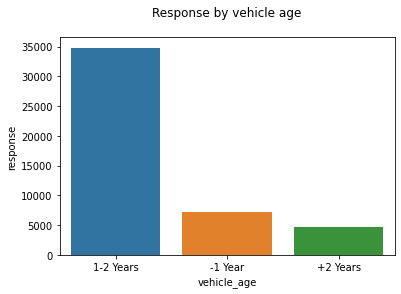

In [48]:
#vehicle age
df2[['vehicle_age', 'response']].head()
aux = df2[['vehicle_age', 'response']].groupby('vehicle_age').sum().reset_index()
ax =sns.barplot(x='vehicle_age', y='response', data=aux);
ax.set_title('Response by vehicle age\n');
ax.set_xticklabels(['1-2 Years', '-1 Year', '+2 Years']);

The difference in this variable, but it would be nice to investigate correlation with other features.

In [49]:
aux = df2[['vehicle_age','response']].value_counts(normalize=True).reset_index()
aux.sort_values('vehicle_age')

,vehicle_age,response,0
0,between_1_and_2_years,0,0.434285
2,between_1_and_2_years,1,0.091328
1,less_than_1_year,0,0.413488
4,less_than_1_year,1,0.018897
3,more_than_2_years,0,0.029663
5,more_than_2_years,1,0.012338


Cars with vehicle age of more than 2 years is bad for the model because there is no big difference between them.

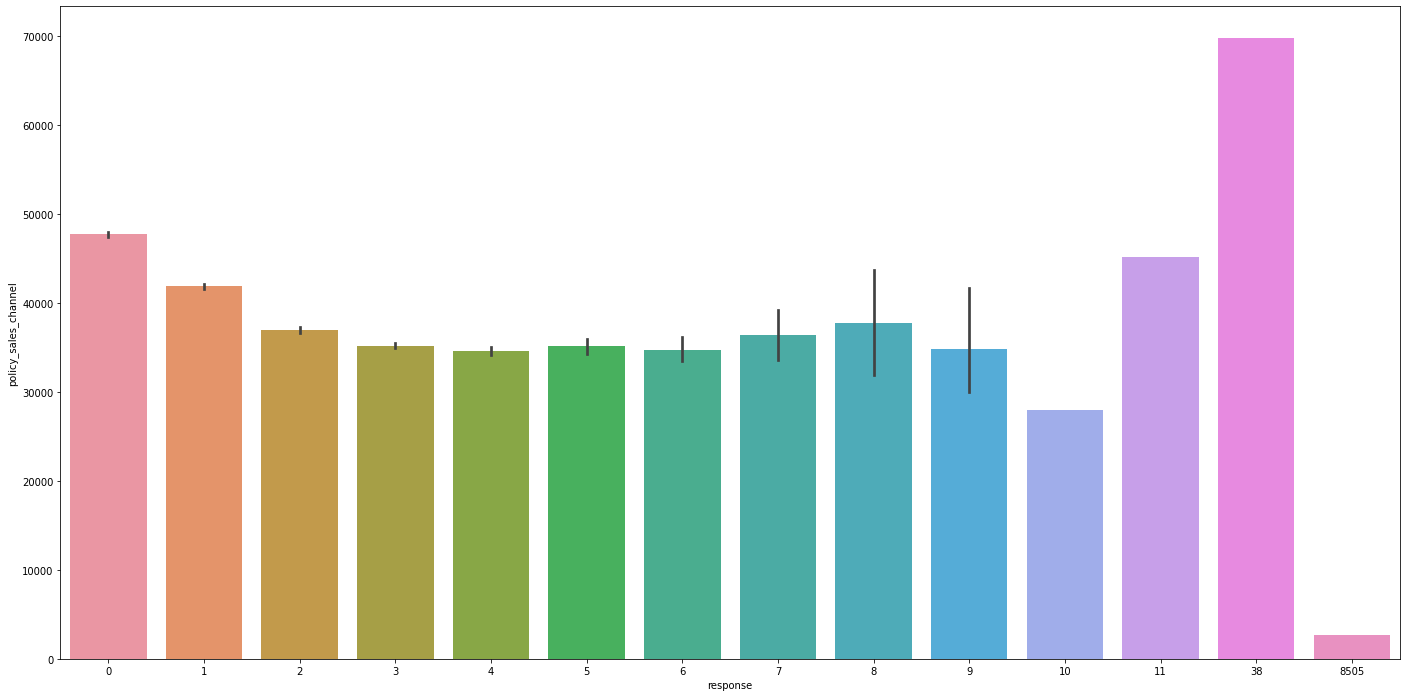

In [50]:

aux = df2[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
plt.figure(figsize=(24,12));
sns.barplot(x='response', y='policy_sales_channel', data =aux);

<AxesSubplot:xlabel='response', ylabel='vintage'>

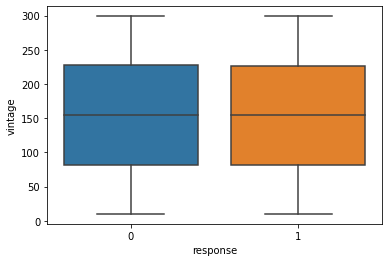

In [51]:
#vintage

sns.boxplot(x='response', y='vintage', data=df2)

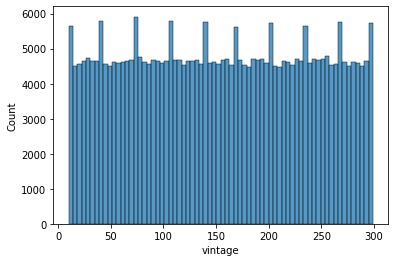

In [52]:
aux00 = df2.loc[df2['response']==0,'vintage']
sns.histplot(aux00);

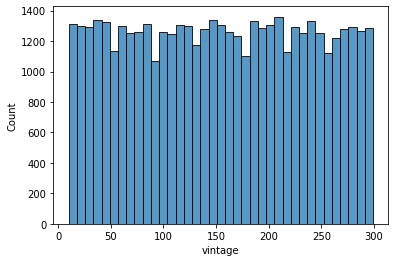

In [53]:
aux00 = df2.loc[df2['response']==1,'vintage']
sns.histplot(aux00);

This feature seems to be unimportant

## 3.2. Multivariable Analisys


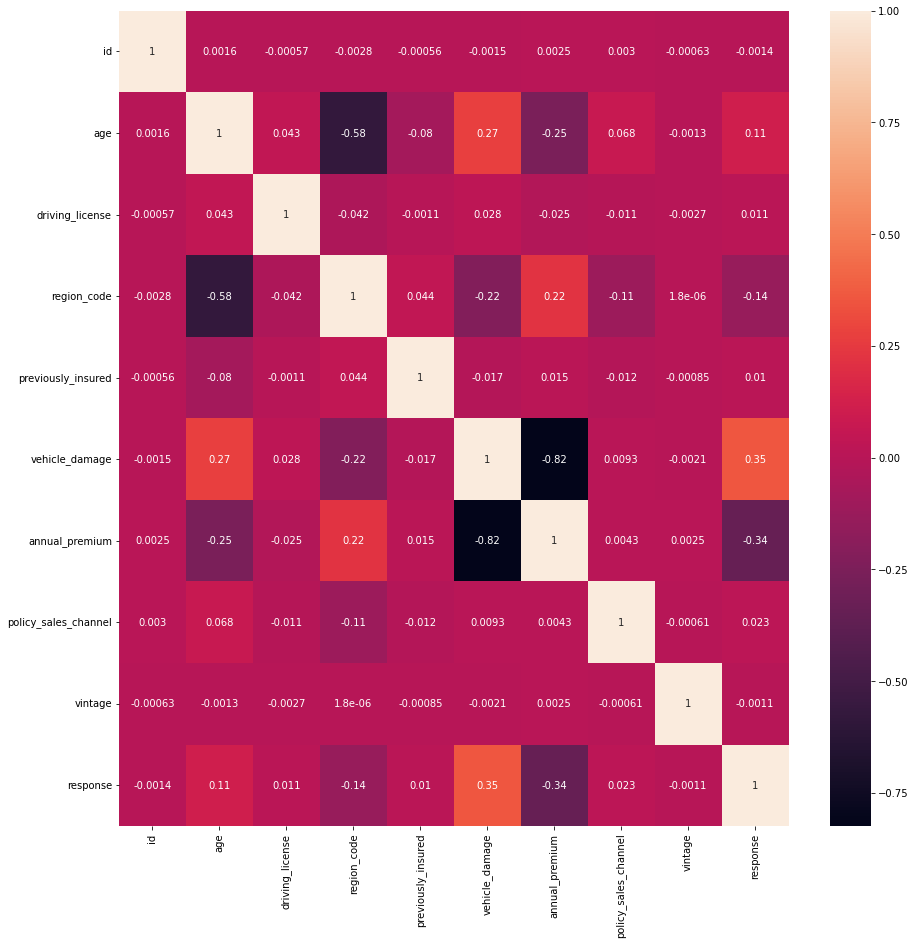

In [54]:
correlation = num_attributes.corr( method='pearson' )
plt.figure(figsize=(15,15))
sns.heatmap(correlation, annot=True);

# 4.0. Data Preparation

In [55]:
df3 = df2.copy()

X = df3.drop('response', axis=1)
y = df3['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.2)

df3 = pd.concat([x_train, y_train], axis=1)

annual_premium_scaler = pickle.load(open('../webapp/features/annual_premium_scaler.pkl', 'rb'))
age_scaler =  pickle.load(open('../webapp/features/age_scaler.pkl', 'rb'))
vintage_scaler = pickle.load(open('../webapp/features/vintage_scaler.pkl', 'rb'))
region_code_encode = pickle.load(open('../webapp/features/region_code_encode.pkl', 'rb'))
policy_sales_channel_encode = pickle.load( open('../webapp/features/policy_sales_channel_encode.pkl', 'rb'))
gender_encode = pickle.load(open('../webapp/features/gender_encode.pkl', 'rb'))

## Standardization

In [56]:


#annual premium
df3['annual_premium'] = annual_premium_scaler.transform(df3[['annual_premium']].values)


## Rescaling

In [57]:
#age
df3['age'] = age_scaler.transform(df3[['age']].values)

#vintage
df3['vintage'] = vintage_scaler.transform(df3[['vintage']].values)


## Encoder

In [58]:
#vehicle age -- One Hot Encoding / Order Target Encoding / Frequency Encoding
# df3 = pd.get_dummies(df3, prefix='vehicle_age', columns=['vehicle_age'])



#region code -- Target Encoding / Weighted Target Encoding / Frequency Encoding
df3.loc[:,'region_code'] = df3['region_code'].map(region_code_encode)
# pickle.dump(target_encode_region_code, open(r'features/region_code_encode.pkl', 'wb'))

#policy_sales_channel -- Target Encoding / Frequency Encoding
df3.loc[:,'policy_sales_channel'] = df3['policy_sales_channel'].map(policy_sales_channel_encode)
# pickle.dump(fe_policy_sales_channel, open(r'features/policy_sales_channel_encode.pkl', 'wb'))


#gender -- Target Encoding
df3.loc[:,'gender'] = df3['gender'].map(gender_encode)
# pickle.dump(target_encode_gender, open(r'features/gender_encode.pkl', 'wb'))

## 4.4. Validation Preparation

In [59]:
#vehicle age 
# x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

#region code 
x_validation.loc[:,'region_code'] = x_validation.loc[:,'region_code'].map(region_code_encode)

#policy_sales_channel 
x_validation.loc[:,'policy_sales_channel'] = x_validation.loc[:,'policy_sales_channel'].map(policy_sales_channel_encode)

#gender 
x_validation.loc[:,'gender'] = x_validation.loc[:,'gender'].map(gender_encode)

#age
x_validation['age'] = age_scaler.transform(x_validation[['age']].values)

#vintage
x_validation['vintage'] = vintage_scaler.transform(x_validation[['vintage']].values)

#annual premium
x_validation['annual_premium'] = annual_premium_scaler.transform(x_validation[['annual_premium']].values)

# fillna
x_validation = x_validation.fillna( 0 )




In [60]:
#vehicle age 
x_train = pd.get_dummies(x_train, prefix='vehicle_age', columns=['vehicle_age'])

#region code 
x_train.loc[:,'region_code'] = x_train.loc[:,'region_code'].map(region_code_encode)

#policy_sales_channel 
x_train.loc[:,'policy_sales_channel'] = x_train.loc[:,'policy_sales_channel'].map(policy_sales_channel_encode)

#gender 
x_train.loc[:,'gender'] = x_train.loc[:,'gender'].map(gender_encode)

#age
x_train['age'] = age_scaler.transform(x_train[['age']].values)

#vintage
x_train['vintage'] = vintage_scaler.transform(x_train[['vintage']].values)

#annual premium
x_train['annual_premium'] = annual_premium_scaler.transform(x_train[['annual_premium']].values)

# fillna
x_train = x_train.fillna( 0 )

# 5.0. Feature Selection

In [61]:
df4 = df3.copy()
x_train_n = x_train.values
y_train_n = y_train.values


## 5.2. Boruta as Feature Selector

In [62]:
# #define Random Forest Regressor
# rf = RandomForestRegressor(n_jobs=-1)

# #define boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(x_train_n, y_train_n )

## 5.3. Feature Importancia

In [63]:
# #model definition
# forest = en.ExtraTreesClassifier(n_estimators=250, random_state=3, n_jobs=-1)


# #data preparation
# x_train_n = x_train.drop(['id'],axis=1)
# y_train_n = y_train.values
# forest.fit(x_train_n, y_train_n)

In [64]:
# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# indices = np.argsort(importances)[::-1]

# #print the feature ranking
# print('Feature ranking:')
# df = pd.DataFrame()
# for i, j in zip(x_train_n, forest.feature_importances_):
#     aux = pd.DataFrame({'feature':i, 'importance': j},index=[0])
#     df = pd.concat([df,aux],axis=0)
    
# print(df.sort_values('importance', ascending=False))

# #Plot the impurity-based feature importances of the forest
# plt.figure()
# plt.title('Feature Importances')
# plt.bar(range(x_train_n.shape[1]),importances[indices], color='r', yerr=std[indices], align='center')
# plt.xticks(range(x_train_n.shape[1]),indices)
# plt.xlim([-1, x_train_n.shape[1]])
# plt.show();


# 6.0. Machine Learning

In [65]:
#features selected

cols_selected = ['vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured']

x_train = df3[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

x_train = x_train.fillna( 0 )
x_train.isnull().sum()

knn_model = pickle.load(open('../webapp/model/knn_model.pkl', 'rb'))
lr_model = pickle.load(open('../webapp/model/lr_model.pkl', 'rb'))
xgb_model = pickle.load(open('../webapp/model/xgb_model.pkl', 'rb'))
rf_model = pickle.load(open('../webapp/model/rf_model.pkl', 'rb'))


## 6.1. KNN

In [66]:
#model definition
# knn_model = nh.KNeighborsClassifier(n_neighbors=9)

#model training
knn_model.fit(x_train,y_train)

#model prediction - Poder de generalização
yhat_knn = knn_model.predict_proba(x_val)

# pickle.dump(knn_model, open('../webapp/model/knn_model.pkl', 'wb'))


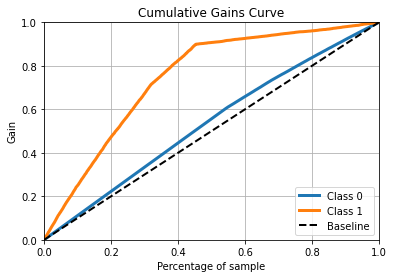

In [67]:
#Accumulative gain
skplt.metrics.plot_cumulative_gain(y_val,yhat_knn);

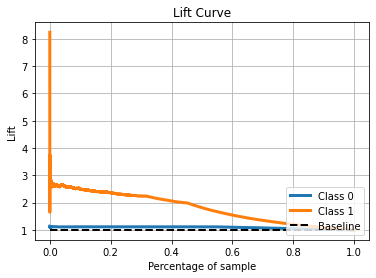

In [68]:
#Lift curve
skplt.metrics.plot_lift_curve(y_val,yhat_knn);

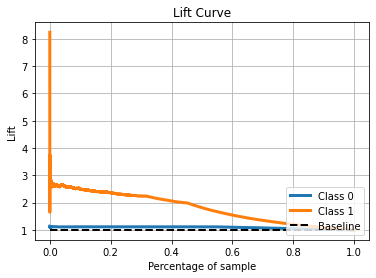

In [69]:
skplt.metrics.plot_lift_curve( y_val, yhat_knn );

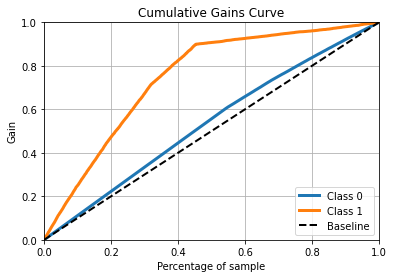

In [70]:
#Accumulative gain
skplt.metrics.plot_cumulative_gain(y_val,yhat_knn);

In [71]:
at_k_metrics( 'KNN', x_validation, y_validation, yhat_knn, k=20000 )

,Precision_at_k,Recall_at_k
KNN,0.275,0.594


### KNN Cross Validation

In [72]:
knn_cv = cross_validation('KNN', knn_model, x_train, y_train)
knn_cv

,Precision_at_k,Recall_at_k
KNN,0.27 +/- 0.0,0.72 +/- 0.0


## 6.2. Logistic Regressor

In [73]:
#model definition
# lr_model = lm.LogisticRegression(random_state=5)

#model training

lr_model.fit(x_train,y_train)

#model prediction
yhat_lr = lr_model.predict_proba(x_val)

# pickle.dump(lr_model, open('../webapp/model/lr_model.pkl', 'wb'))



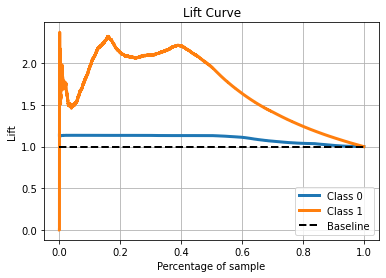

In [74]:
skplt.metrics.plot_lift_curve( y_val, yhat_lr );

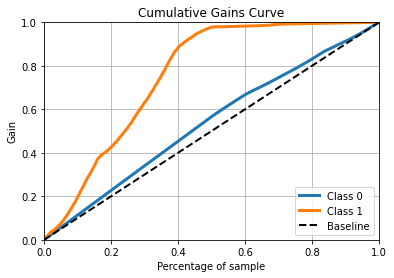

In [75]:
#Accumulative gain
skplt.metrics.plot_cumulative_gain(y_val,yhat_lr);

In [76]:
at_k_metrics( 'Logistic Regressor', x_validation, y_validation, yhat_lr, k=20000 )

,Precision_at_k,Recall_at_k
Logistic Regressor,0.251,0.544


### Logistic Regressor Cross Validation

In [77]:
lr_cv = cross_validation('Logistic Regressor', lr_model, x_train, y_train)
lr_cv

,Precision_at_k,Recall_at_k
Logistic Regressor,0.26 +/- 0.0,0.7 +/- 0.0


## 6.3. XBoost Classifier

In [78]:
#model definition
# xgb_model = XGBClassifier(n_estimators = 1500,
#                           eta = 0.03,
#                           max_depth = 3,
#                           subsample = 0.7,
#                           colsample_bytree = 0.9,
#                           min_child_weight = 3)

#model training
xgb_model.fit(x_train,y_train)

#model prediction
yhat_xgb = xgb_model.predict_proba(x_val)



[20:02:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [79]:
# pickle.dump(xgb_model, open(r'/src/model/xgb_model.pkl', 'wb'))

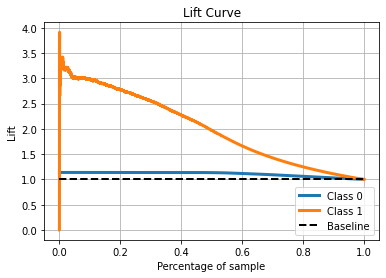

In [80]:
skplt.metrics.plot_lift_curve( y_val, yhat_xgb );

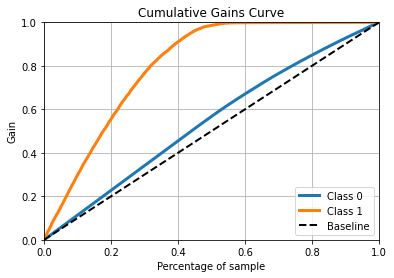

In [81]:
#Accumulative gain
skplt.metrics.plot_cumulative_gain(y_val,yhat_xgb);

In [82]:
at_k_metrics( 'XGBoost Classifier', x_validation, y_validation, yhat_xgb, k=200 )

,Precision_at_k,Recall_at_k
XGBoost Classifier,0.388,0.008


### XGBoost Regressor Cross Validation

In [ ]:
xgb_cv = cross_validation('XGBoost Classifier', xgb_model, x_train, y_train)
xgb_cv


[20:03:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:04:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:05:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:06:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [ ]:
# pickle.dump(xgb_model, open(r'/src/model/xgb_model.pkl', 'wb'))

In [ ]:
skplt.metrics.plot_lift_curve( y_val, yhat_xgb );

In [ ]:
#Accumulative gain
skplt.metrics.plot_cumulative_gain(y_val,yhat_xgb);

In [ ]:
at_k_metrics( 'XGBoost Classifier', x_validation, y_validation, yhat_xgb, k=200 )

### XGBoost Cross Validation

In [ ]:
xgb_cv = cross_validation('XGBoost Classifier', xgb_model, x_train, y_train)
xgb_cv

# 8.0 Hyperparameter Fine Tunning

In [ ]:
# import random

# param = {
# 'n_estimators': [1500, 1700, 2500, 3000, 3500],
# 'eta': [0.01, 0.03],
# 'max_depth': [3, 5, 9],
# 'subsample': [0.1, 0.5, 0.7],
# 'colsample_bytree': [0.3, 0.7, 0.9],
# 'min_child_weight': [3, 8, 15]
# }

# MAX_EVAL = 5

# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):

# # choose values for parameters randomly

#     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#     print( hp )
#     # model

#     model_xgb = XGBClassifier( objective='reg:squarederror',
#     n_estimators=hp['n_estimators'],
#     eta=hp['eta'],
#     max_depth=hp['max_depth'],
#     subsample=hp['subsample'],
#     colsample_bytee=hp['colsample_bytree'],
#     min_child_weight=hp['min_child_weight'] )


#     # performance
#     result = cross_validation('XGBoost Classifier', xgb_model, x_train, y_train)
#     final_result = pd.concat( [final_result, result] )
# #
# #final_result

In [ ]:
results_cv = pd.concat([knn_cv, lr_cv, xgb_cv])
results_cv


## 8.1. Bootstrap

In [ ]:

# np.random.seed(42)
statistics = []

for i in range(1000):
    
    np.random.seed(i)     #mudando a amostragem a cada iteração
    #sampling
    df4 = x_train.copy()   #criando dataset com dados já preparados
    df4['response'] = y_train.copy()   #incrementando a respost

    sample = df4.sample(100)   #criando sample de 100 
    X_sample = sample.drop('response', axis=1)   #separando o x do sample
    y_sample = sample['response']         #separando o y do sample
    
    # #predict
    yhat_xgb_ = xgb_model.predict_proba(X_sample)[:,1]  #calculando a probabilidade de ser verdadeiro
    stat = metrics.roc_auc_score(y_sample, yhat_xgb_)   #utilizando roc auc score como métrica
    statistics.append(stat)              #agregando na lista
    
    #repetindo...
    
np.mean(statistics) #tirando a média dos roc auc score


#confidence interval
alpha = 0.95
ordered = statistics.sort
lower = np.percentile(statistics, (1-alpha)/2)
upper = np.percentile(statistics, alpha+((1-alpha)/2))


In [ ]:
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

In [ ]:
sns.histplot(statistics, bins=10);

In [ ]:


from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier


# np.random.seed(42)
statistics_ = []

n_iterations = 1000
n_size = 100
warnings.simplefilter("ignore")

df4 = x_train.copy()   #criando dataset com dados já preparados
df4['response'] = y_train.copy()   #incrementando a respost
values = df4.values
for i in range(1000):
    
    np.random.seed(i)     #mudando a amostragem a cada iteração
    print(i)
    #sampling
    train = resample(values, n_samples=n_size)
    test = np.array([x for x in values if x.tolist() not in train.tolist()])

    model = DecisionTreeClassifier()
    #fit
    model.fit(train[:,:-1], train[:,-1])
    
    #predict
    pred = model.predict(test[:,:-1])  #predição 
    stat = metrics.accuracy_score(test[:,-1], pred)   #utilizando accuracy score como métrica
    statistics_.append(stat)              #append na lista
    
    #repetindo...
    
np.mean(statistics_) #tirando a média dos accuracy score

In [ ]:
sns.histplot(statistics_, bins=10);

In [ ]:
#confidence interval
alpha = 0.95
ordered = statistics_.sort
lower = np.percentile(statistics_, (1-alpha)/2)
upper = np.percentile(statistics_, alpha+((1-alpha)/2))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

# 9.0 Deploy to Production

## 9.1. Class HealthInsurance

In [ ]:
class HealthInsurance():
    def __init__(self):
        #paths
        self.path = '/home/heitor/repos/health_insurance_cross_sale/'
        self.annual_premium_scaler = pickle.load(ss, open(self.path + r'../src/features/annual_premium_scaler.pkl', 'rb'))
        self.age_scaler =  pickle.load(mms_age, open(self.path + r'../src/features/age_scaler.pkl', 'rb'))
        self.vintage_scaler = pickle.load(mms_vintage, open(self.path + r'../src/features/vintage_scaler.pkl', 'rb'))
        self.region_code_encode = pickle.load(target_encode_region_code, open(self.path + r'../src/features/region_code_encode.pkl', 'rb'))
        self.policy_sales_channel_encode = pickle.load(fe_policy_sales_channel, open(self.path + r'../src/features/policy_sales_channel_encode.pkl', 'rb'))
        self.gender_encode = pickle.load(target_encode_gender, open(self.path + r'../src/features/gender_encode.pkl', 'rb'))
        
                                                                                    
    def data_cleaning(data):
                                                                                     #Rename columns
        old_cols = ['id', 'Gender', 'Age', 'DrivingLicense', 'RegionCode','PreviouslyInsured', 'Vehicle_Age', 'VehicleDamage', 'AnnualPremium','PolicySalesChannel', 'Vintage', 'Response']
        snakecase = lambda x: inflection.underscore(x)

        new_cols = list(map(snakecase, old_cols))
        data.columns = new_cols

        #changing types

        data['vehicle_damage'] = data['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        data['policy_sales_channel'] = data['policy_sales_channel'].astype(int)
        data['annual_premium'] = data['annual_premium'].astype(int)
        data['region_code'] = data['region_code'].astype(int)
        data['vehicle_damage'] = data['vehicle_damage'].astype(int)
        return data
                                                                                     
                                                                                     
    def feature_engineering(data):
        data['vehicle_age'] = data['vehicle_age'].apply(lambda x: 'less_than_1_year' if x =='< 1 Year' else
                                                                  'more_than_2_years' if x== '> 2 Years' else
                                                                  'between_1_and_2_years' )
        return data
                                                                                     
    def data_preparation(data):
        X = data.drop('response', axis=1)
        y = data['response'].copy()
        x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.2)
        data = pd.concat([x_train, y_train], axis=1)

        #annual premium
        df3['annual_premium'] = self.annual_premium_scaler.transform(df3[['annual_premium']].values)

        #age
        data['age'] = self.age_scaler.transform(data[['age']].values)

        #vintage
        data['vintage'] = self.vintage_scaler.transform(data[['vintage']].values)

        #vehicle age -- One Hot Encoding / Order Target Encoding / Frequency Encoding
        data = pd.get_dummies(data, prefix='vehicle_age', columns=['vehicle_age'])

        #region code -- Target Encoding / Weighted Target Encoding / Frequency Encoding
        data.loc[:,'region_code'] = data['region_code'].map(self.region_code_encode)

        #policy_sales_channel -- Target Encoding / Frequency Encoding
        data.loc[:,'policy_sales_channel'] = data['policy_sales_channel'].map(policy_sales_channel_encode)

        #gender -- Target Encoding
        data.loc[:,'gender'] = data['gender'].map(self.gender_encode)

        #features selected
        cols_selected = ['vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured']
        

        return data[cols_selected]
       
    def get_prediction(self, model, original_data, test_data):
        #model prediction
        pred = mode.predict_proba(test_data)
        
        #join prediction into original data
        original_data['score'] = pred
        
        return original_data.to_json(orient='records',data_format='iso')

## 9.2. API Handler

In [ ]:
from healthinsurance import HealthInsurance
import pickle
import pandas as pd
from flask import Flask, request, Response
import os

#loading model
model = pickle.load(xgb_model_tunned, open(r'../src/model/xgb_model.pkl', 'rb'))

#initialize API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def healthinsurance_predict():
    test_json = request.get_json()
    if test_json: #there is data
        if isinstance(test_jason, dict):  #unique example 
            test_raw = pd.DataFrame(test_json, index=[0])
        
        else:                             #multiple example
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
            
            #Initialize HealthInsurance Class
            pipeline = HealthInsurance()
            
            #data cleaning
            data = data_cleaning(test_raw)
            
            #feature engineering
            data = feature_engineering(data)
            
            #data preparation
            data = data_preparation(data)
            
            #prediction
            df_response = get_prediction(model, test_raw, data)
            
            return df_response
        
    
    else:
        return Response('{}', status = 200, mimetype = 'application/json')

if __name__ == 'main':
    port = os.environ.get('PORT', 5000)
    app.run('0.0.0.0', port=port)
    
            
            
            




## 9.3. API Tester

In [ ]:
import requests
# import json

In [ ]:
df_test = x_validation

In [ ]:
df_test = df_test.sample(10)

In [ ]:
#convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [ ]:
#API Call
url = 'https://health-insurance-cross2.herokuapp.com/predict'
header = { 'Content-type': 'application/json' }


r = requests.post( url, data=data, headers=header )
print( 'Status Code: {}'.format( r.status_code ) )

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()

# 10.0. Relatório 

* Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.


## 10.1. Insights da EDA

##### Features que mais impactam nessa decisão segundo o Extra Trees Classifier em ordem descrescente de importância

1. vintage - tempo que usa seguro
2. annual_premium - valor gasto anualmente com a empresa
3. age - idade
4. region_code - código da região 
5. vehicle_damage - condição se já danificou o veículo 
6. policy_sales_channel - canal de comunicação
7. previously_insured - se já possui 


* Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?


In [ ]:
perc = 100*20000/len(y_val)


print('20.000 representa {:.2f}% da base de validação'.format(perc))



In [ ]:
#Accumulative gain
skplt.metrics.plot_cumulative_gain(y_val,yhat_xgb);



Ao analisar o ganho acumulado para 26% da base, alcançaremos aproximadamente 80% dos clientes interessados.



* E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?


In [ ]:
perc = 100*40000/len(y_val)


print('40.000 representa {:.2f}% da base de validação'.format(perc))
print('Ao analisar o ganho acumulado para {:.2f}% da base, alcançaremos aproximadamente 100% dos clientes interessados.'.format(perc))
